In [1]:
import os
import time
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
import eigen_analysis

cols = eigen_analysis.LINUX_COLS
time_unit = eigen_analysis.TIME_CONVERSION_khz
joules_unit = eigen_analysis.JOULE_CONVERSION

In [3]:
# get all itrs explored for some (dvfs, qps) pair
def list_itrs(rdtsc_dirname):
    itrs = []
    for file in os.listdir(rdtsc_dirname):
        tags = file.split('_')
        itr = tags[1]
        itrs.append(itr)
    itrs = list(set(itrs))
    return itrs

In [77]:
app = 'mcdsilo'
run = '0'
rapl = '135'
dvfs = '0x1300'
qps = '200k'
itr = '10'

In [78]:
app_dir = app + '_' + run + '_rapl_' + rapl + '/'
logs_dir = app_dir + qps + '_qps/linux_' + app + '_dmesg_' + run + '_' + dvfs + '_' + rapl + '_' + qps + '/'
cores = []
cores = !ls $logs_dir | cut -d '_' -f2 | sort | uniq
#cores = [c for c in range(0, 16)]

In [79]:
global itrs
global cores
global app_dir

In [80]:
cores

['0',
 '1',
 '10',
 '11',
 '12',
 '13',
 '14',
 '2',
 '3',
 '4',
 '5',
 '6',
 '7',
 '8',
 '9']

In [10]:
def print_err_log(dvfs, qps, itr, rapl='135', run='0', err_dir = app_dir + 'err_logs/'):
    err_filename = 'err_log_' + run + '_' + itr + '_' + dvfs + '_' + rapl + '_' + qps[:-1] + '000'
    if os.path.exists(err_dir + err_filename):
        err_file = open(err_dir + err_filename, 'r')
        print(err_file.read())
    else:
        print('EMPTY ERROR LOG')

In [11]:
def handle_neg_diffs(df_diffs, df, core, err_file):
    
    tmp = df_diffs.copy()

    # isolating rows with negative diffs
    tmp_neg = tmp[(tmp['joules_diff'] < 0) | (tmp['instructions_diff'] < 0) | (tmp['cycles_diff'] < 0) \
                   | (tmp['ref_cycles_diff'] < 0) | (tmp['llc_miss_diff'] < 0) | (tmp['timestamp_diff'] < 0)]

    # re-computing diffs if possible; else dropping rows
    for i,j in tmp_neg.iterrows():
        prev = df.shift(1).loc[i]
        cur = df.loc[i]
        # TODO note that we are only handling case of RAPL-energy-status register overflow
        if (tmp.loc[i]['joules_diff'] < 0) & (tmp.loc[i]['timestamp_diff'] >= 0.001):
            err_file.write('CORE ' + str(core) + '  ---  JOULES COUNTER OVERFLOW AT LOG ENTRY DIFF #' + str(i) + '\n')
            tmp.loc[i, ['joules_diff']] = (2**32 - 1) * joules_unit - prev['joules'] + cur['joules'] 
        else:
            err_file.write('CORE ' + str(core) + '  ---  UNEXPLAINED NEGATIVE VALS AT LOG ENTRY DIFF # ' + str(i) + '\n')
            cols = ''
            prevs = ''
            currs = ''
            for col in list(df.columns):
                cols += col + '  '
                prevs += str(prev[col]) + '  '
                currs += str(cur[col]) + '  '
            err_file.write('          ' + cols + '\n')
            err_file.write('         log[' + str(i-1) + ']: ' + prevs + '\n')
            err_file.write('         log[' + str(i) + ']: ' + currs + '\n')
            tmp = tmp.drop(i, axis=0)

    return tmp

### Correlation matrices and eigenvals:

In [83]:
def per_core_corr(dvfs, qps, itr, app, rapl='135', run='0'):

    app_dir = app + '_' + run + '_rapl_' + rapl + '/'
    corr_dir = app_dir + qps + '_corr/'
    
    # here are all the log files for this dvfs & qps
    logs_dir = app_dir + qps + '_qps/linux_' + app + '_dmesg_' + run + '_' + dvfs + '_' + rapl + '_' + qps + '/'
    # here are all the time-management files for this dvfs & qps
    rdtsc_dir = app_dir + qps + '_qps/linux_' + app + '_rdtsc_' + run + '_' + dvfs + '_' + rapl + '_' + qps +'/'
    rdtsc_file = rdtsc_dir + 'linux.' + app + '.rdtsc.' + run + '_' + itr + '_' + dvfs + '_' + rapl + '_' + qps[:-1] + '000'
    start, end = eigen_analysis.get_rdtsc(rdtsc_file)

    # initializing error log file
    err_dir = app_dir + 'err_logs/'
    err_filename = 'err_log_' + run + '_' + itr + '_' + dvfs + '_' + rapl + '_' + qps[:-1] + '000'
    err_file = open(err_dir + err_filename, 'w')

    counters_corr_dict = {}
    non_counters_corr_dict = {}
    cores = []
    cores = !ls $logs_dir | cut -d '_' -f2 | sort | uniq
    #cores = [c for c in range(0, 16)]
    for c in cores:
        
        # check if corr matrices have been precomputed
        counters_corr_outdir = corr_dir + qps + '_' + dvfs + '_counters_corr/'
        counters_corr_outfile = counters_corr_outdir + dvfs + '_' + qps + '_' + itr + '_counters_' + c + '_corr'
        non_counters_corr_outdir = corr_dir + qps + '_' + dvfs + '_non_counters_corr/'
        non_counters_corr_outfile = non_counters_corr_outdir + dvfs + '_' + qps + '_' + itr + '_non_counters_' + c + '_corr'
        if os.path.exists(counters_corr_outfile):
            counters_corr = pd.read_csv(counters_corr_outfile, index_col=0)
            counters_corr_dict[str(c)] = counters_corr
            if os.path.exists(non_counters_corr_outfile):
                non_counters_corr = pd.read_csv(non_counters_corr_outfile, index_col=0)
                non_counters_corr_dict[str(c)] = non_counters_corr
                continue
        
        # otherwise, compute corr matrices
        file = logs_dir + 'linux.' + app + '.dmesg.' + run + '_' + str(c) + '_' + itr + '_' + dvfs + '_' + rapl + '_' + qps[:-1] + '000'
        print('Uncompressing log file..')
        !gunzip -v $file'.gz'    
        df = pd.read_csv(file, sep = ' ', names = cols, index_col='i')
        print('Compressing log file..')
        !gzip -v9 $file
        
        df = df[(df['timestamp'] >= start) & (df['timestamp'] <= end)]
        df.loc[:, 'timestamp'] = df['timestamp'] - df['timestamp'].min()
        df.loc[:, 'timestamp'] = df['timestamp'] * time_unit
        df.loc[:, 'joules'] = df['joules'] * joules_unit
        
        counters_df = df[['joules', 'instructions', 'cycles', 'ref_cycles', 'llc_miss', 'timestamp']].copy()
        counters_df = counters_df[(counters_df['joules'] > 0) & (counters_df['instructions'] > 0) \
                                            & (counters_df['cycles'] > 0) & (counters_df['ref_cycles'] > 0) \
                                            & (counters_df['llc_miss'] > 0)]
        # computing diffs of counter readings
        df_diffs = counters_df.diff().dropna().copy()
        df_diffs.columns = [f'{c}_diff' for c in df_diffs.columns]
        df_diffs = handle_neg_diffs(df_diffs, counters_df, c, err_file)
        df_corr = df_diffs.drop(['timestamp_diff', 'joules_diff'], axis = 1).corr()
        counters_corr_dict[str(c)] = df_corr
        # saving corr matrix
        !mkdir -p $counters_corr_outdir
        df_corr.to_csv(counters_corr_outfile)

        non_counters_df = df[['rx_bytes', 'rx_desc', 'tx_bytes', 'tx_desc']].copy()
        df_corr = non_counters_df.corr()
        non_counters_corr_dict[str(c)] = df_corr
        # saving corr matrix
        !mkdir -p $non_counters_corr_outdir
        df_corr.to_csv(non_counters_corr_outfile)
        
    return counters_corr_dict, non_counters_corr_dict

In [82]:
def merged_core_corr(dvfs, qps, itr, app, rapl='135', run='0'):
    app_dir = app + '_' + run + '_rapl_' + rapl + '/'
    merged_dir = app_dir + qps + '_merged/'
    corr_dir = app_dir + qps + '_merged_corr/'

    # check if corr matrices have been precomputed
    counters_corr_outdir = corr_dir + qps + '_' + dvfs + '_counters_merged_corr/'
    counters_corr_outfile = counters_corr_outdir + dvfs + '_' + qps + '_' + itr + '_counters_merged_corr'
    non_counters_corr_outdir = corr_dir + qps + '_' + dvfs + '_non_counters_merged_corr/'
    non_counters_corr_outfile = non_counters_corr_outdir + dvfs + '_' + qps + '_' + itr + '_non_counters_merged_corr'
    if os.path.exists(counters_corr_outfile):
        counters_corr = pd.read_csv(counters_corr_outfile, index_col=0)
        if os.path.exists(non_counters_corr_outfile):
            non_counters_corr = pd.read_csv(non_counters_corr_outfile, index_col=0)
            return counters_corr, non_counters_corr

    merged_counters_dir = merged_dir + qps + '_' + dvfs + '_counters_merged/'
    merged_non_counters_dir = merged_dir + qps + '_' + dvfs + '_non_counters_merged/'
    merged_counters_file = merged_counters_dir + dvfs + '_' + qps + '_' + itr + '_counters_merged'
    merged_non_counters_file = merged_non_counters_dir + dvfs + '_' + qps + '_' + itr + '_non_counters_merged'
    
    print('Uncompressing merged log files..')
    !gunzip -v $merged_counters_file'.gz'    
    !gunzip -v $merged_non_counters_file'.gz'    
    counters_df = pd.read_csv(merged_counters_file, index_col=0)
    non_counters_df = pd.read_csv(merged_non_counters_file, index_col=0)
    counters_corr = counters_df.drop(['timestamp', 'joules_diff'], axis = 1).corr()
    # saving corr matrix
    !mkdir -p $counters_corr_outdir
    counters_corr.to_csv(counters_corr_outfile)
    
    print('Compressing merged log files..')
    !gzip -v9 $merged_counters_file    
    !gzip -v9 $merged_non_counters_file    
    non_counters_corr = non_counters_df.drop(['timestamp'], axis = 1).corr()
    # saving corr matrix
    !mkdir -p $non_counters_corr_outdir
    non_counters_corr.to_csv(non_counters_corr_outfile)    
    
    return counters_corr, non_counters_corr

In [84]:
counters_corr_dict, non_counters_corr_dict = per_core_corr(dvfs, qps, itr, app)
merged_counters_corr, merged_non_counters_corr = merged_core_corr(dvfs, qps, itr, app)

In [86]:
counters_corr_dict['5']

,instructions_diff,cycles_diff,ref_cycles_diff,llc_miss_diff
instructions_diff,1.000000,0.940980,0.940980,0.895877
cycles_diff,0.940980,1.000000,1.000000,0.946947
ref_cycles_diff,0.940980,1.000000,1.000000,0.946947
llc_miss_diff,0.895877,0.946947,0.946947,1.000000


In [87]:
non_counters_corr_dict['10']

,rx_bytes,rx_desc,tx_bytes,tx_desc
rx_bytes,1.000000,0.977036,-0.656227,-0.655762
rx_desc,0.977036,1.000000,-0.674514,-0.674117
tx_bytes,-0.656227,-0.674514,1.000000,0.999709
tx_desc,-0.655762,-0.674117,0.999709,1.000000


In [88]:
merged_counters_corr

,instructions_diff,cycles_diff,ref_cycles_diff,llc_miss_diff
instructions_diff,1.000000,0.945073,0.945072,0.904792
cycles_diff,0.945073,1.000000,1.000000,0.945082
ref_cycles_diff,0.945072,1.000000,1.000000,0.945082
llc_miss_diff,0.904792,0.945082,0.945082,1.000000


In [89]:
merged_non_counters_corr

,rx_bytes,rx_desc,tx_bytes,tx_desc
rx_bytes,1.000000,0.977798,-0.670873,-0.670532
rx_desc,0.977798,1.000000,-0.688284,-0.688008
tx_bytes,-0.670873,-0.688284,1.000000,0.999737
tx_desc,-0.670532,-0.688008,0.999737,1.000000


In [109]:
from numpy.linalg import eig, eigvalsh

def get_per_core_eigvals(cores, dvfs, qps, itr, app, rapl='135', run='0'):
    
    app_dir = app + '_' + run + '_rapl_' + rapl + '/'
    corr_dir = app_dir + qps + '_corr/'
    counters_corr_dir = corr_dir + qps + '_' + dvfs + '_counters_corr/'
    non_counters_corr_dir = corr_dir + qps + '_' + dvfs + '_non_counters_corr/'

    counters_corr_dict = {}
    non_counters_corr_dict = {}
    all_core_eigvals = {}
    for c in cores:
        counters_corr_file = counters_corr_dir + dvfs + '_' + qps + '_' + itr + '_counters_' + c + '_corr'
        counters_corr_dict[c] = pd.read_csv(counters_corr_file, index_col=0)
        counter_vals, vecs = eig(counters_corr_dict[str(c)])
        for i in range(0, len(counter_vals)):
            counter_vals[i] = counter_vals[i] / counter_vals[0]
        non_counters_corr_file = non_counters_corr_dir + dvfs + '_' + qps + '_' + itr + '_non_counters_' + c + '_corr'
        non_counters_corr_dict[c] = pd.read_csv(non_counters_corr_file, index_col=0)
        non_counter_vals, vecs = eig(non_counters_corr_dict[str(c)])
        for i in range(0, len(non_counter_vals)):
            non_counter_vals[i] = non_counter_vals[i] / non_counter_vals[0]
        all_core_eigvals[str(c)] = np.concatenate([np.log(counter_vals[1:4]) , np.log(non_counter_vals[1:4])])

    return all_core_eigvals
        
def get_merged_eigvals(dvfs, qps, itr, app, rapl='135', run='0'):
    
    app_dir = app + '_' + run + '_rapl_' + rapl + '/'
    corr_dir = app_dir + qps + '_merged_corr/'
    merged_counters_corr_dir = corr_dir + qps + '_' + dvfs + '_counters_merged_corr/'
    merged_non_counters_corr_dir = corr_dir + qps + '_' + dvfs + '_non_counters_merged_corr/'
    
    merged_counters_corr_file = merged_counters_corr_dir + dvfs + '_' + qps + '_' + itr + '_counters_merged_corr'
    merged_counters_corr = pd.read_csv(merged_counters_corr_file, index_col=0)
    merged_counter_vals, merged_vecs = eig(merged_counters_corr)
    for i in range(0, len(merged_counter_vals)):
        merged_counter_vals[i] = merged_counter_vals[i] / merged_counter_vals[0]
    merged_non_counters_corr_file = merged_non_counters_corr_dir + dvfs + '_' + qps + '_' + itr + '_non_counters_merged_corr'
    merged_non_counters_corr = pd.read_csv(merged_non_counters_corr_file, index_col=0)
    merged_non_counter_vals, merged_vecs = eig(merged_non_counters_corr)
    for i in range(0, len(merged_non_counter_vals)):
        merged_non_counter_vals[i] = merged_non_counter_vals[i] / merged_non_counter_vals[0]    
    merged_eigvals = np.concatenate([np.log(merged_counter_vals[1:4]), np.log(merged_non_counter_vals[1:4])])
    
    return merged_eigvals

In [91]:
eigvals = get_per_core_eigvals(cores, dvfs, qps, itr, app)
eigvals['merged'] = get_merged_eigvals(dvfs, qps, itr, app)

In [92]:
eigvals

{'0': array([ -1.7723863 ,  -2.35498382, -20.24975865,  -0.34813965,
         -3.71006567,  -7.85348999]),
 '1': array([ -2.33051601,  -2.8364201 , -20.3045395 ,  -0.52214547,
         -3.95406061,  -8.67667356]),
 '10': array([ -2.16682749,  -2.5834082 , -20.42574145,  -0.41813057,
         -3.78753945,  -8.14310455]),
 '11': array([ -2.28926128,  -2.85540489, -20.29347485,  -0.52857065,
         -3.92869228,  -8.59151278]),
 '12': array([ -1.86355859,  -2.42595018, -20.34170081,  -0.34757725,
         -3.72914359,  -7.91350197]),
 '13': array([ -2.67036229,  -2.95792347, -20.23541946,  -0.81781098,
         -3.98736581,  -9.14822924]),
 '14': array([ -2.45488931,  -2.66341385, -20.62243297,  -0.50859798,
         -3.90742554,  -8.41030477]),
 '2': array([ -2.58347171,  -2.85053105, -20.43846605,  -0.61424246,
         -3.95316697,  -8.8679024 ]),
 '3': array([ -2.29128058,  -2.847368  , -20.34905835,  -0.51889371,
         -3.87956963,  -8.57137714]),
 '4': array([ -2.08734196,  -2.5

In [105]:
def plot_eig_vals(eig_dict, dvfs, qps, itr, app):
    plt.figure(figsize=(10,6))
    num_eig = len(list(eig_dict.values())[0])
    eig_list = [str(i) for i in range(0, num_eig)]
    for core in eig_dict.keys():   
        vals = eig_dict[core]
        if core == 'merged':
            plt.plot(eig_list, vals, 'x', label='merged') 
        else:
            plt.plot(eig_list, vals, 'p', label='core ' + str(core))
    plt.xlabel('eigval id')
    plt.ylabel('log( eigval / max_eigval )')
    plt.ylim(-25)
    plt.title(f'{app}: Eigvals of Per-Core and Merged Corr Matrices (ITR-DELAY = {itr}, DVFS = {dvfs}, QPS = {qps})')
    plt.legend()
    plt.show()
    plt.savefig(app_dir + 'plots/eigvals_'+ dvfs + '_' + qps + '_' + itr)

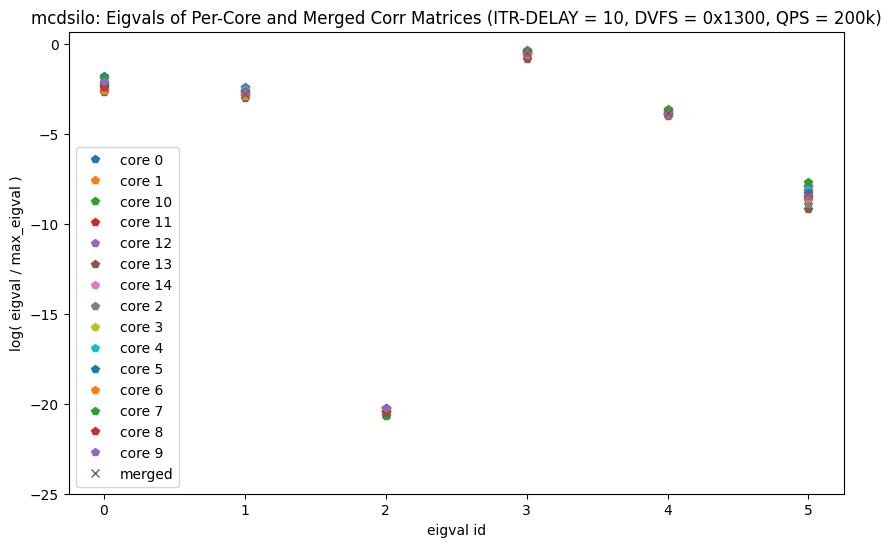

<Figure size 640x480 with 0 Axes>

In [106]:
plot_eig_vals(eigvals, dvfs, qps, itr, app)

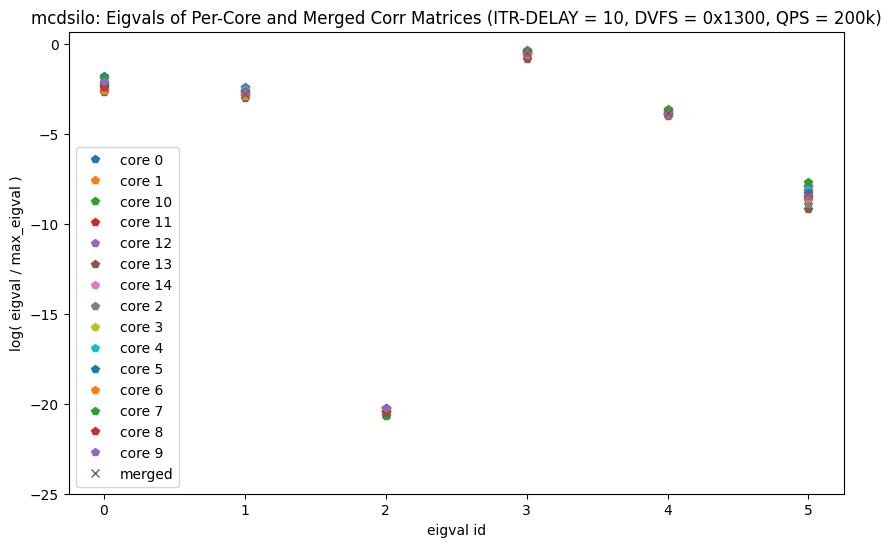

<Figure size 640x480 with 0 Axes>

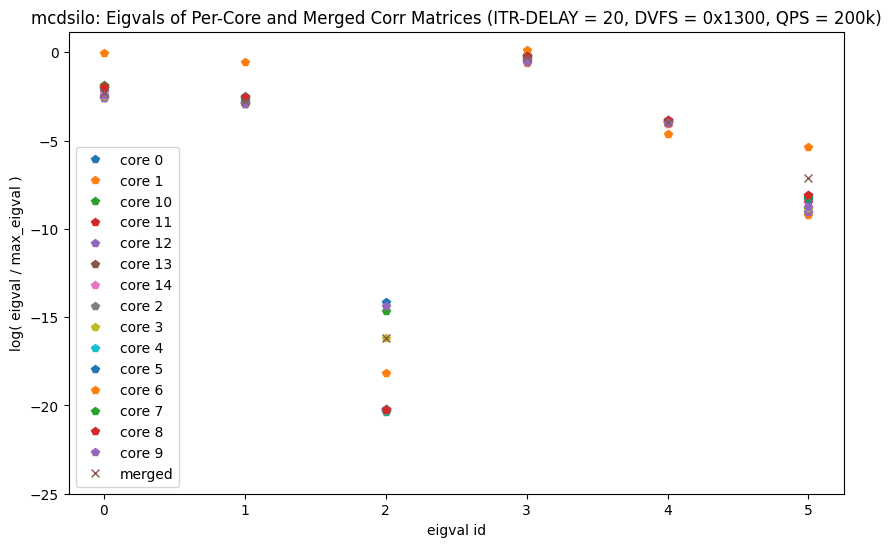

<Figure size 640x480 with 0 Axes>

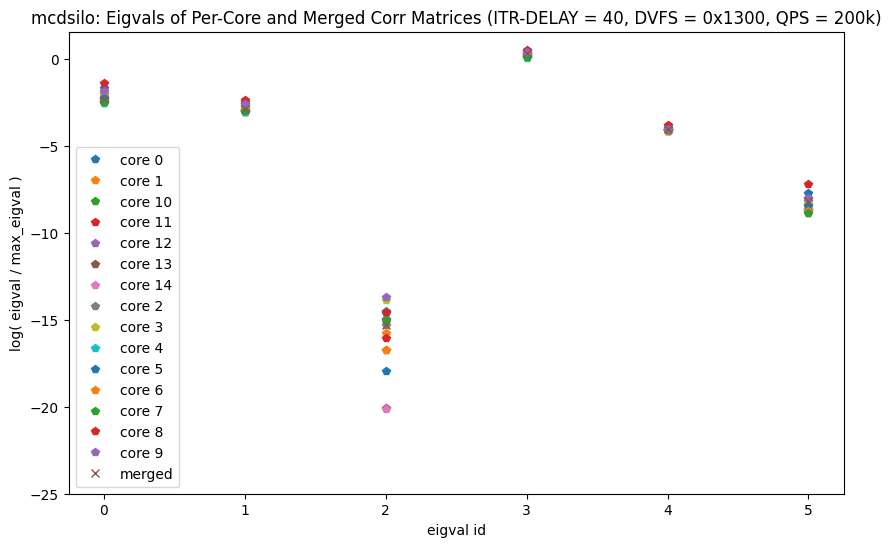

<Figure size 640x480 with 0 Axes>

In [108]:
for dvfs in ['0x1300']:
    for qps in ['200k']:
        for itr in ['10', '20', '40']:
            counters_corr_dict, non_counters_corr_dict = per_core_corr(dvfs, qps, itr, app)
            merged_counters_corr, merged_non_counters_corr = merged_core_corr(dvfs, qps, itr, app)
            eigvals = get_per_core_eigvals(cores, dvfs, qps, itr, app)
            eigvals['merged'] = get_merged_eigvals(dvfs, qps, itr, app)
            plot_eig_vals(eigvals, dvfs, qps, itr, app)